In [3]:
import pandas as pd
import numpy as np
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score
from scipy.spatial.distance import cdist

# Load your dataset
file_path = 'F:/precip/precip/paper/final_filtered_data33.xlsx'
df = pd.read_excel(file_path)

# Define the date range of interest
start_date = 136801
end_date = 139612

# Convert 'Date' to numeric if it's not already
df['Date'] = pd.to_numeric(df['Date'], errors='coerce')

# Pivot the DataFrame to get stations as columns and Date as index
pivot_df = df.pivot(index='Date', columns='station', values='precipitation')

# Filter the data by the specified date range
filtered_df = pivot_df[(pivot_df.index >= start_date) & (pivot_df.index <= end_date)]

# Extract location coordinates
locations = df[['station', 'X', 'Y']].drop_duplicates().set_index('station')

# Calculate Euclidean distances between stations
def calculate_distances(locations):
    coords = locations[['X', 'Y']].values
    distances = cdist(coords, coords, metric='euclidean')
    return distances

# Convert distances to kilometers (assuming UTM coordinates in meters)
def convert_to_kilometers(distances):
    return distances / 1000

# Calculate and convert distances
distances = calculate_distances(locations)
distances_km = convert_to_kilometers(distances)

# Identify stations with missing values
stations_with_missing_data = filtered_df.columns[filtered_df.isnull().any()]

# Dynamically create distance groups, increasing by 10 km intervals
distance_step = 10
max_distance = np.max(distances_km)  # Use max distance between all stations
distance_groups = [(0, i) for i in range(distance_step, int(np.ceil(max_distance)) + distance_step, distance_step)]

# Dictionary to store evaluation metrics for each station and group
evaluation_results = []

# Function to find suitable stations based only on distance within a group
def find_suitable_stations_by_group(station_with_missing_data, group):
    suitable_stations = []
    
    for station in filtered_df.columns:
        if station != station_with_missing_data:
            # Calculate distance between the current station and other stations
            distance = distances_km[locations.index.get_loc(station_with_missing_data), locations.index.get_loc(station)]
            if group[0] <= distance < group[1]:
                suitable_stations.append(station)
    
    return suitable_stations

# Evaluate model performance for each station with missing values
for target_station in stations_with_missing_data:
    print(f"\nEvaluating for target station: {target_station}")
    
    for group in distance_groups:
        group_name = f"{group[0]}-{group[1]} km"
        print(f"\nEvaluating group: {group_name}")
        
        # Find suitable stations for the target station
        suitable_stations = find_suitable_stations_by_group(target_station, group)
        
        if suitable_stations:
            combined_df = filtered_df[[target_station] + suitable_stations].copy()
            combined_df = combined_df.dropna(subset=[target_station])
            
            if len(combined_df) < 10:  # Example check for minimum data points
                print(f"Not enough data points for station {target_station} in group {group_name}.")
                continue
            
            X = combined_df[suitable_stations].values
            y = combined_df[target_station].values
            
            valid_indices = ~np.isnan(y)
            X = X[valid_indices]
            y = y[valid_indices]
            
            # Define the pipeline
            pipeline = Pipeline([
                ('scaler', StandardScaler()),
                ('regr', HistGradientBoostingRegressor())
            ])
            
            # Perform cross-validation and calculate average metrics
            cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring='r2')  # Using R² as the scoring metric
            mean_r2 = np.mean(cv_scores)
            
            # Calculate additional metrics using a split for demonstration
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
            pipeline.fit(X_train, y_train)
            y_pred = pipeline.predict(X_test)
            
            mse = mean_squared_error(y_test, y_pred)
            rmse = np.sqrt(mse)
            mae = mean_absolute_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)
            
            evaluation_results.append({
                'Distance Group': group_name,
                'Station': target_station,
                'Mean R2 CV': mean_r2,
                'MSE': mse,
                'RMSE': rmse,
                'MAE': mae,
                'R2': r2
            })
            
            print(f"R² Score for station {target_station} in group {group_name}: {r2:.4f}")
            print(f"Mean R² from Cross-Validation for station {target_station} in group {group_name}: {mean_r2:.4f}")
        else:
            print(f"No suitable stations found for station {target_station} in group {group_name}.")

# Convert results to DataFrames
results_df = pd.DataFrame(evaluation_results)

# Optionally, save the evaluation results to an Excel file
results_df.to_excel('F:/precip/precip/paper/evaluation_results_consolidated.xlsx', index=False)



Evaluating for target station: 19-936

Evaluating group: 0-10 km
No suitable stations found for station 19-936 in group 0-10 km.

Evaluating group: 0-20 km
R² Score for station 19-936 in group 0-20 km: 0.7963
Mean R² from Cross-Validation for station 19-936 in group 0-20 km: 0.7490

Evaluating group: 0-30 km
R² Score for station 19-936 in group 0-30 km: 0.7527
Mean R² from Cross-Validation for station 19-936 in group 0-30 km: 0.7318

Evaluating group: 0-40 km
R² Score for station 19-936 in group 0-40 km: 0.7917
Mean R² from Cross-Validation for station 19-936 in group 0-40 km: 0.7135

Evaluating group: 0-50 km
R² Score for station 19-936 in group 0-50 km: 0.7918
Mean R² from Cross-Validation for station 19-936 in group 0-50 km: 0.7007

Evaluating group: 0-60 km
R² Score for station 19-936 in group 0-60 km: 0.7947
Mean R² from Cross-Validation for station 19-936 in group 0-60 km: 0.7032

Evaluating group: 0-70 km
R² Score for station 19-936 in group 0-70 km: 0.8198
Mean R² from Cross-V

D:\anacon\envs\sep_2021\Lib\site-packages\sklearn\utils\extmath.py:1050: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
D:\anacon\envs\sep_2021\Lib\site-packages\sklearn\utils\extmath.py:1055: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
D:\anacon\envs\sep_2021\Lib\site-packages\sklearn\utils\extmath.py:1075: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


R² Score for station 31-101 in group 0-120 km: 0.7400
Mean R² from Cross-Validation for station 31-101 in group 0-120 km: 0.7281

Evaluating group: 0-130 km


D:\anacon\envs\sep_2021\Lib\site-packages\sklearn\utils\extmath.py:1050: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
D:\anacon\envs\sep_2021\Lib\site-packages\sklearn\utils\extmath.py:1055: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
D:\anacon\envs\sep_2021\Lib\site-packages\sklearn\utils\extmath.py:1075: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


R² Score for station 31-101 in group 0-130 km: 0.7540
Mean R² from Cross-Validation for station 31-101 in group 0-130 km: 0.7274

Evaluating group: 0-140 km


D:\anacon\envs\sep_2021\Lib\site-packages\sklearn\utils\extmath.py:1050: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
D:\anacon\envs\sep_2021\Lib\site-packages\sklearn\utils\extmath.py:1055: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
D:\anacon\envs\sep_2021\Lib\site-packages\sklearn\utils\extmath.py:1075: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


R² Score for station 31-101 in group 0-140 km: 0.7365
Mean R² from Cross-Validation for station 31-101 in group 0-140 km: 0.7272

Evaluating group: 0-150 km


D:\anacon\envs\sep_2021\Lib\site-packages\sklearn\utils\extmath.py:1050: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
D:\anacon\envs\sep_2021\Lib\site-packages\sklearn\utils\extmath.py:1055: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
D:\anacon\envs\sep_2021\Lib\site-packages\sklearn\utils\extmath.py:1075: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


R² Score for station 31-101 in group 0-150 km: 0.7322
Mean R² from Cross-Validation for station 31-101 in group 0-150 km: 0.7271

Evaluating group: 0-160 km


D:\anacon\envs\sep_2021\Lib\site-packages\sklearn\utils\extmath.py:1050: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
D:\anacon\envs\sep_2021\Lib\site-packages\sklearn\utils\extmath.py:1055: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
D:\anacon\envs\sep_2021\Lib\site-packages\sklearn\utils\extmath.py:1075: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


R² Score for station 31-101 in group 0-160 km: 0.7410
Mean R² from Cross-Validation for station 31-101 in group 0-160 km: 0.7197

Evaluating group: 0-170 km


D:\anacon\envs\sep_2021\Lib\site-packages\sklearn\utils\extmath.py:1050: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
D:\anacon\envs\sep_2021\Lib\site-packages\sklearn\utils\extmath.py:1055: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
D:\anacon\envs\sep_2021\Lib\site-packages\sklearn\utils\extmath.py:1075: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


R² Score for station 31-101 in group 0-170 km: 0.7316
Mean R² from Cross-Validation for station 31-101 in group 0-170 km: 0.7351

Evaluating group: 0-180 km


D:\anacon\envs\sep_2021\Lib\site-packages\sklearn\utils\extmath.py:1050: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
D:\anacon\envs\sep_2021\Lib\site-packages\sklearn\utils\extmath.py:1055: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
D:\anacon\envs\sep_2021\Lib\site-packages\sklearn\utils\extmath.py:1075: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


R² Score for station 31-101 in group 0-180 km: 0.7341
Mean R² from Cross-Validation for station 31-101 in group 0-180 km: 0.7391

Evaluating group: 0-190 km


D:\anacon\envs\sep_2021\Lib\site-packages\sklearn\utils\extmath.py:1050: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
D:\anacon\envs\sep_2021\Lib\site-packages\sklearn\utils\extmath.py:1055: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
D:\anacon\envs\sep_2021\Lib\site-packages\sklearn\utils\extmath.py:1075: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


R² Score for station 31-101 in group 0-190 km: 0.7548
Mean R² from Cross-Validation for station 31-101 in group 0-190 km: 0.7402

Evaluating group: 0-200 km


D:\anacon\envs\sep_2021\Lib\site-packages\sklearn\utils\extmath.py:1050: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
D:\anacon\envs\sep_2021\Lib\site-packages\sklearn\utils\extmath.py:1055: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
D:\anacon\envs\sep_2021\Lib\site-packages\sklearn\utils\extmath.py:1075: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


R² Score for station 31-101 in group 0-200 km: 0.7402
Mean R² from Cross-Validation for station 31-101 in group 0-200 km: 0.7372

Evaluating group: 0-210 km


D:\anacon\envs\sep_2021\Lib\site-packages\sklearn\utils\extmath.py:1050: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
D:\anacon\envs\sep_2021\Lib\site-packages\sklearn\utils\extmath.py:1055: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
D:\anacon\envs\sep_2021\Lib\site-packages\sklearn\utils\extmath.py:1075: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


R² Score for station 31-101 in group 0-210 km: 0.7455
Mean R² from Cross-Validation for station 31-101 in group 0-210 km: 0.7344

Evaluating group: 0-220 km


D:\anacon\envs\sep_2021\Lib\site-packages\sklearn\utils\extmath.py:1050: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
D:\anacon\envs\sep_2021\Lib\site-packages\sklearn\utils\extmath.py:1055: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
D:\anacon\envs\sep_2021\Lib\site-packages\sklearn\utils\extmath.py:1075: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


R² Score for station 31-101 in group 0-220 km: 0.7455
Mean R² from Cross-Validation for station 31-101 in group 0-220 km: 0.7344

Evaluating group: 0-230 km


D:\anacon\envs\sep_2021\Lib\site-packages\sklearn\utils\extmath.py:1050: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
D:\anacon\envs\sep_2021\Lib\site-packages\sklearn\utils\extmath.py:1055: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
D:\anacon\envs\sep_2021\Lib\site-packages\sklearn\utils\extmath.py:1075: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


R² Score for station 31-101 in group 0-230 km: 0.7455
Mean R² from Cross-Validation for station 31-101 in group 0-230 km: 0.7344

Evaluating group: 0-240 km


D:\anacon\envs\sep_2021\Lib\site-packages\sklearn\utils\extmath.py:1050: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
D:\anacon\envs\sep_2021\Lib\site-packages\sklearn\utils\extmath.py:1055: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
D:\anacon\envs\sep_2021\Lib\site-packages\sklearn\utils\extmath.py:1075: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


R² Score for station 31-101 in group 0-240 km: 0.7455
Mean R² from Cross-Validation for station 31-101 in group 0-240 km: 0.7344

Evaluating group: 0-250 km


D:\anacon\envs\sep_2021\Lib\site-packages\sklearn\utils\extmath.py:1050: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
D:\anacon\envs\sep_2021\Lib\site-packages\sklearn\utils\extmath.py:1055: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
D:\anacon\envs\sep_2021\Lib\site-packages\sklearn\utils\extmath.py:1075: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


R² Score for station 31-101 in group 0-250 km: 0.7455
Mean R² from Cross-Validation for station 31-101 in group 0-250 km: 0.7344

Evaluating group: 0-260 km


D:\anacon\envs\sep_2021\Lib\site-packages\sklearn\utils\extmath.py:1050: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
D:\anacon\envs\sep_2021\Lib\site-packages\sklearn\utils\extmath.py:1055: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
D:\anacon\envs\sep_2021\Lib\site-packages\sklearn\utils\extmath.py:1075: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


R² Score for station 31-101 in group 0-260 km: 0.7455
Mean R² from Cross-Validation for station 31-101 in group 0-260 km: 0.7344

Evaluating group: 0-270 km


D:\anacon\envs\sep_2021\Lib\site-packages\sklearn\utils\extmath.py:1050: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
D:\anacon\envs\sep_2021\Lib\site-packages\sklearn\utils\extmath.py:1055: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
D:\anacon\envs\sep_2021\Lib\site-packages\sklearn\utils\extmath.py:1075: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


R² Score for station 31-101 in group 0-270 km: 0.7455
Mean R² from Cross-Validation for station 31-101 in group 0-270 km: 0.7344

Evaluating group: 0-280 km


D:\anacon\envs\sep_2021\Lib\site-packages\sklearn\utils\extmath.py:1050: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
D:\anacon\envs\sep_2021\Lib\site-packages\sklearn\utils\extmath.py:1055: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
D:\anacon\envs\sep_2021\Lib\site-packages\sklearn\utils\extmath.py:1075: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


R² Score for station 31-101 in group 0-280 km: 0.7455
Mean R² from Cross-Validation for station 31-101 in group 0-280 km: 0.7344

Evaluating group: 0-290 km


D:\anacon\envs\sep_2021\Lib\site-packages\sklearn\utils\extmath.py:1050: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
D:\anacon\envs\sep_2021\Lib\site-packages\sklearn\utils\extmath.py:1055: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
D:\anacon\envs\sep_2021\Lib\site-packages\sklearn\utils\extmath.py:1075: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


R² Score for station 31-101 in group 0-290 km: 0.7455
Mean R² from Cross-Validation for station 31-101 in group 0-290 km: 0.7344

Evaluating group: 0-300 km


D:\anacon\envs\sep_2021\Lib\site-packages\sklearn\utils\extmath.py:1050: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
D:\anacon\envs\sep_2021\Lib\site-packages\sklearn\utils\extmath.py:1055: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
D:\anacon\envs\sep_2021\Lib\site-packages\sklearn\utils\extmath.py:1075: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


R² Score for station 31-101 in group 0-300 km: 0.7455
Mean R² from Cross-Validation for station 31-101 in group 0-300 km: 0.7344

Evaluating group: 0-310 km


D:\anacon\envs\sep_2021\Lib\site-packages\sklearn\utils\extmath.py:1050: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
D:\anacon\envs\sep_2021\Lib\site-packages\sklearn\utils\extmath.py:1055: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
D:\anacon\envs\sep_2021\Lib\site-packages\sklearn\utils\extmath.py:1075: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


R² Score for station 31-101 in group 0-310 km: 0.7455
Mean R² from Cross-Validation for station 31-101 in group 0-310 km: 0.7344

Evaluating group: 0-320 km


D:\anacon\envs\sep_2021\Lib\site-packages\sklearn\utils\extmath.py:1050: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
D:\anacon\envs\sep_2021\Lib\site-packages\sklearn\utils\extmath.py:1055: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
D:\anacon\envs\sep_2021\Lib\site-packages\sklearn\utils\extmath.py:1075: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


R² Score for station 31-101 in group 0-320 km: 0.7455
Mean R² from Cross-Validation for station 31-101 in group 0-320 km: 0.7344

Evaluating for target station: 31-109

Evaluating group: 0-10 km
No suitable stations found for station 31-109 in group 0-10 km.

Evaluating group: 0-20 km
R² Score for station 31-109 in group 0-20 km: 0.3972
Mean R² from Cross-Validation for station 31-109 in group 0-20 km: 0.4435

Evaluating group: 0-30 km
R² Score for station 31-109 in group 0-30 km: 0.4883
Mean R² from Cross-Validation for station 31-109 in group 0-30 km: 0.5340

Evaluating group: 0-40 km
R² Score for station 31-109 in group 0-40 km: 0.6223
Mean R² from Cross-Validation for station 31-109 in group 0-40 km: 0.5657

Evaluating group: 0-50 km
R² Score for station 31-109 in group 0-50 km: 0.6623
Mean R² from Cross-Validation for station 31-109 in group 0-50 km: 0.6178

Evaluating group: 0-60 km
R² Score for station 31-109 in group 0-60 km: 0.6280
Mean R² from Cross-Validation for station 31-

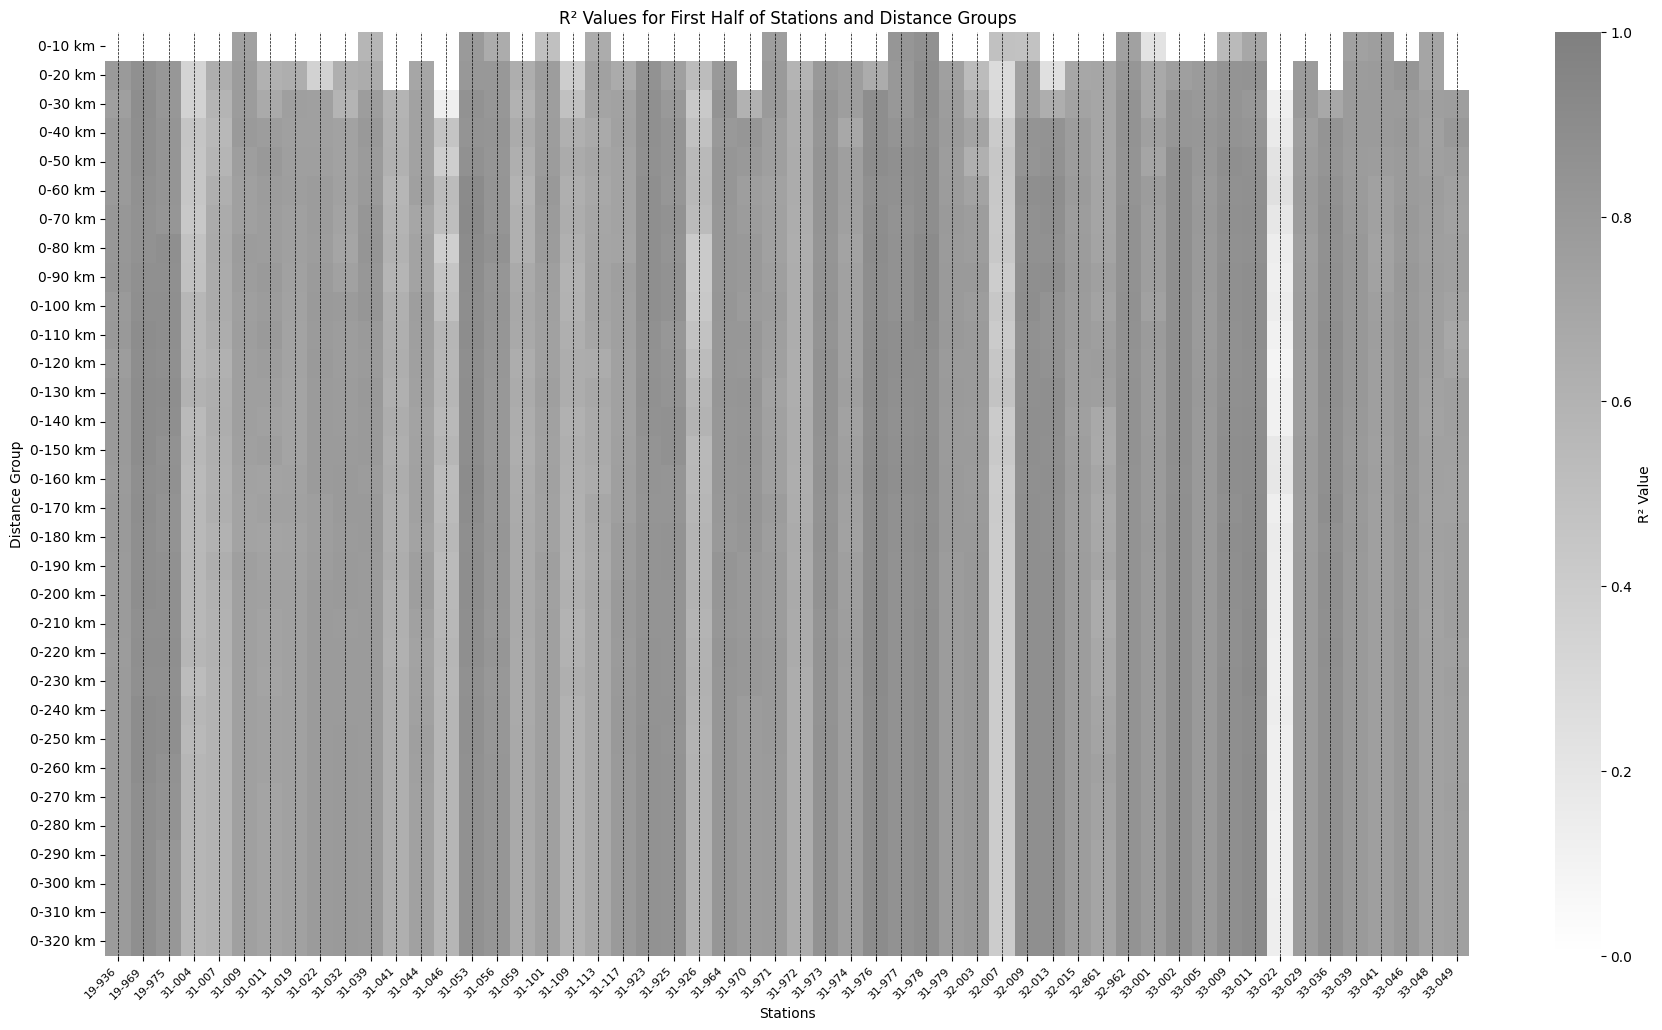

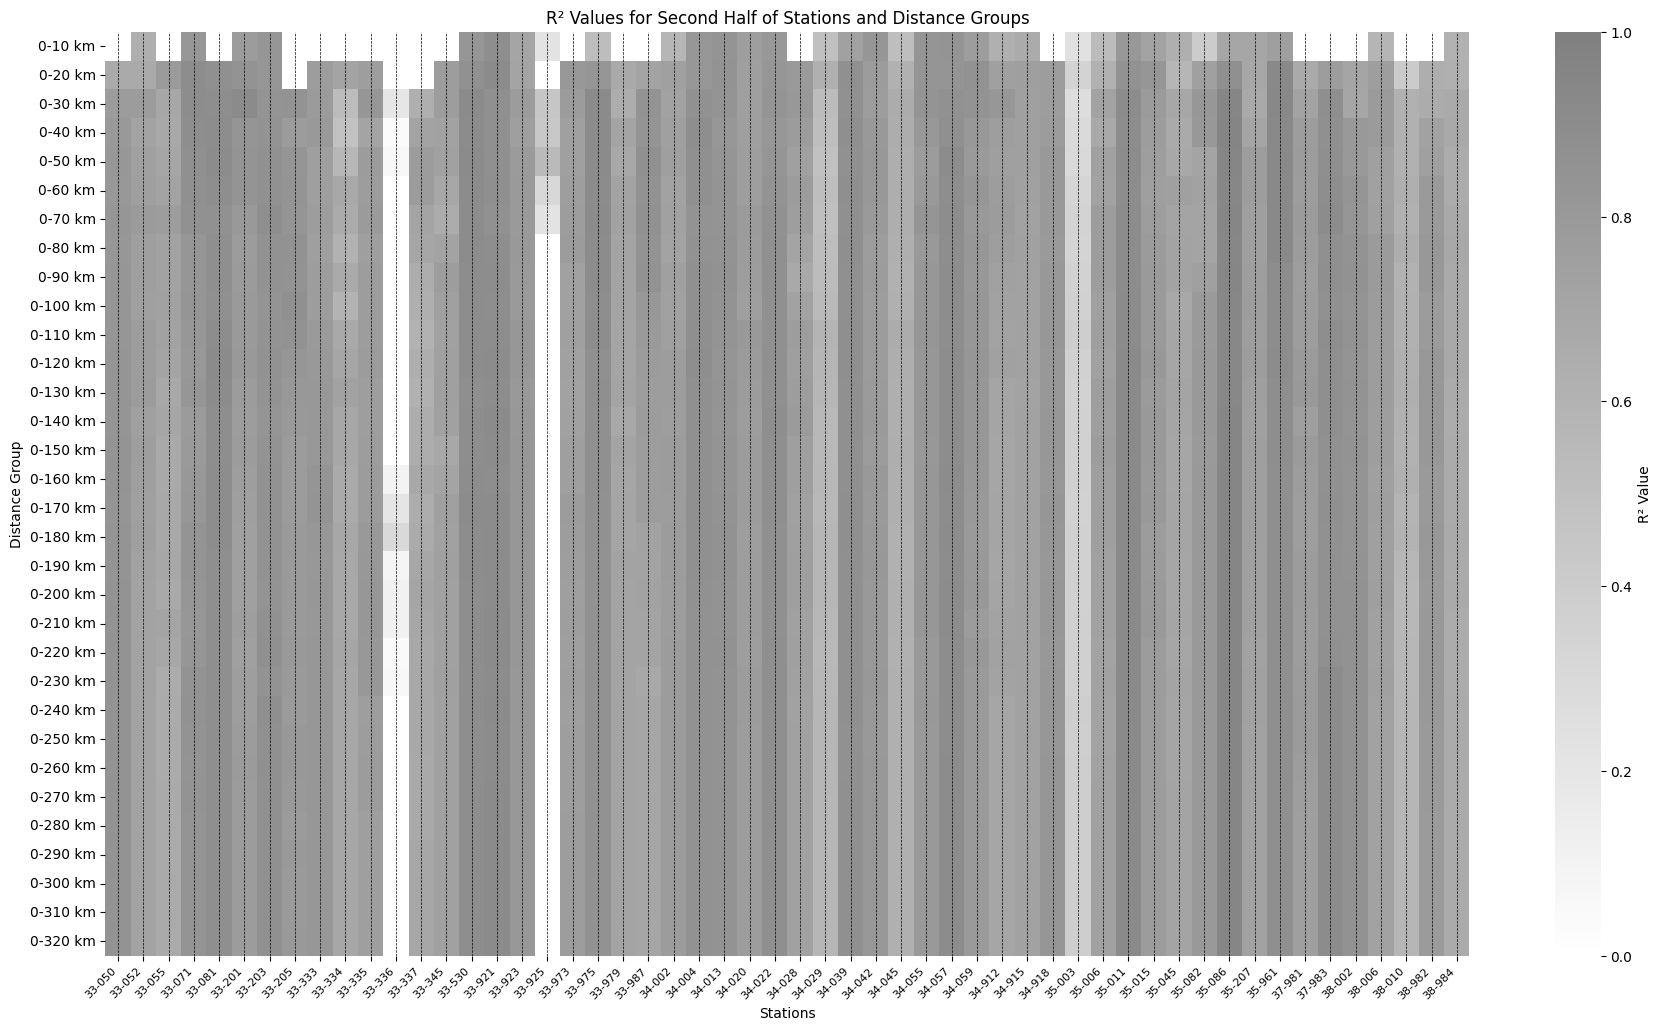

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

# Define the output folder for plots
output_plot_folder = 'F:/precip/precip/paper/'

# Function to extract the upper bound of the distance range, handling additional text
def extract_distance_value(distance_group):
    # Remove any non-numeric characters and extract the upper bound
    distance_str = distance_group.split('-')[1].strip()
    distance_value = int(''.join(filter(str.isdigit, distance_str)))
    return distance_value

# Apply the function to create a new column with sortable numeric values
results_df['Distance Value'] = results_df['Distance Group'].apply(extract_distance_value)

# Sort the DataFrame by the new 'Distance Value' column
results_df = results_df.sort_values('Distance Value')

# Pivot data to create a matrix for the heatmap
heatmap_data = results_df.pivot(index='Distance Group', columns='Station', values='R2')

# Ensure Distance Groups are sorted correctly
heatmap_data = heatmap_data.reindex(sorted(heatmap_data.index, key=lambda x: extract_distance_value(x)))

# Split the stations into two halves
stations = heatmap_data.columns
midpoint = len(stations) // 2
stations_first_half = stations[:midpoint]
stations_second_half = stations[midpoint:]

# Create a custom colormap from white to gray
cmap = LinearSegmentedColormap.from_list('gray_white', ['white', 'gray'])

# Create the first heatmap (first half of stations)
heatmap_data_first_half = heatmap_data[stations_first_half]

fig, ax = plt.subplots(figsize=(22, 12))  # Increase width and height for better readability
sns.heatmap(heatmap_data_first_half, cmap=cmap, ax=ax, cbar_kws={'label': 'R² Value'}, annot=False, vmin=0, vmax=1)

# Set gridlines on the x-axis for major ticks
ax.grid(True, which='major', axis='x', color='black', linestyle='--', linewidth=0.5)

ax.set_xlabel('Stations', fontsize=10)  # Adjust font size
ax.set_ylabel('Distance Group', fontsize=10)  # Adjust font size
ax.set_title('R² Values for First Half of Stations and Distance Groups', fontsize=12)  # Adjust font size
plt.xticks(rotation=45, ha='right', fontsize=8)  # Rotate labels and adjust font size
plt.savefig(f'{output_plot_folder}r2_heatmap_first_half22_stations_with_gridlines.png', dpi=300, bbox_inches='tight')
plt.show()

# Create the second heatmap (second half of stations)
heatmap_data_second_half = heatmap_data[stations_second_half]

fig, ax = plt.subplots(figsize=(22, 12))  # Increase width and height for better readability
sns.heatmap(heatmap_data_second_half, cmap=cmap, ax=ax, cbar_kws={'label': 'R² Value'}, annot=False, vmin=0, vmax=1)

# Set gridlines on the x-axis for major ticks
ax.grid(True, which='major', axis='x', color='black', linestyle='--', linewidth=0.5)

ax.set_xlabel('Stations', fontsize=10)  # Adjust font size
ax.set_ylabel('Distance Group', fontsize=10)  # Adjust font size
ax.set_title('R² Values for Second Half of Stations and Distance Groups', fontsize=12)  # Adjust font size
plt.xticks(rotation=45, ha='right', fontsize=8)  # Rotate labels and adjust font size
plt.savefig(f'{output_plot_folder}r2_heatmap22_second_half_stations_with_gridlines.png', dpi=300, bbox_inches='tight')
plt.show()


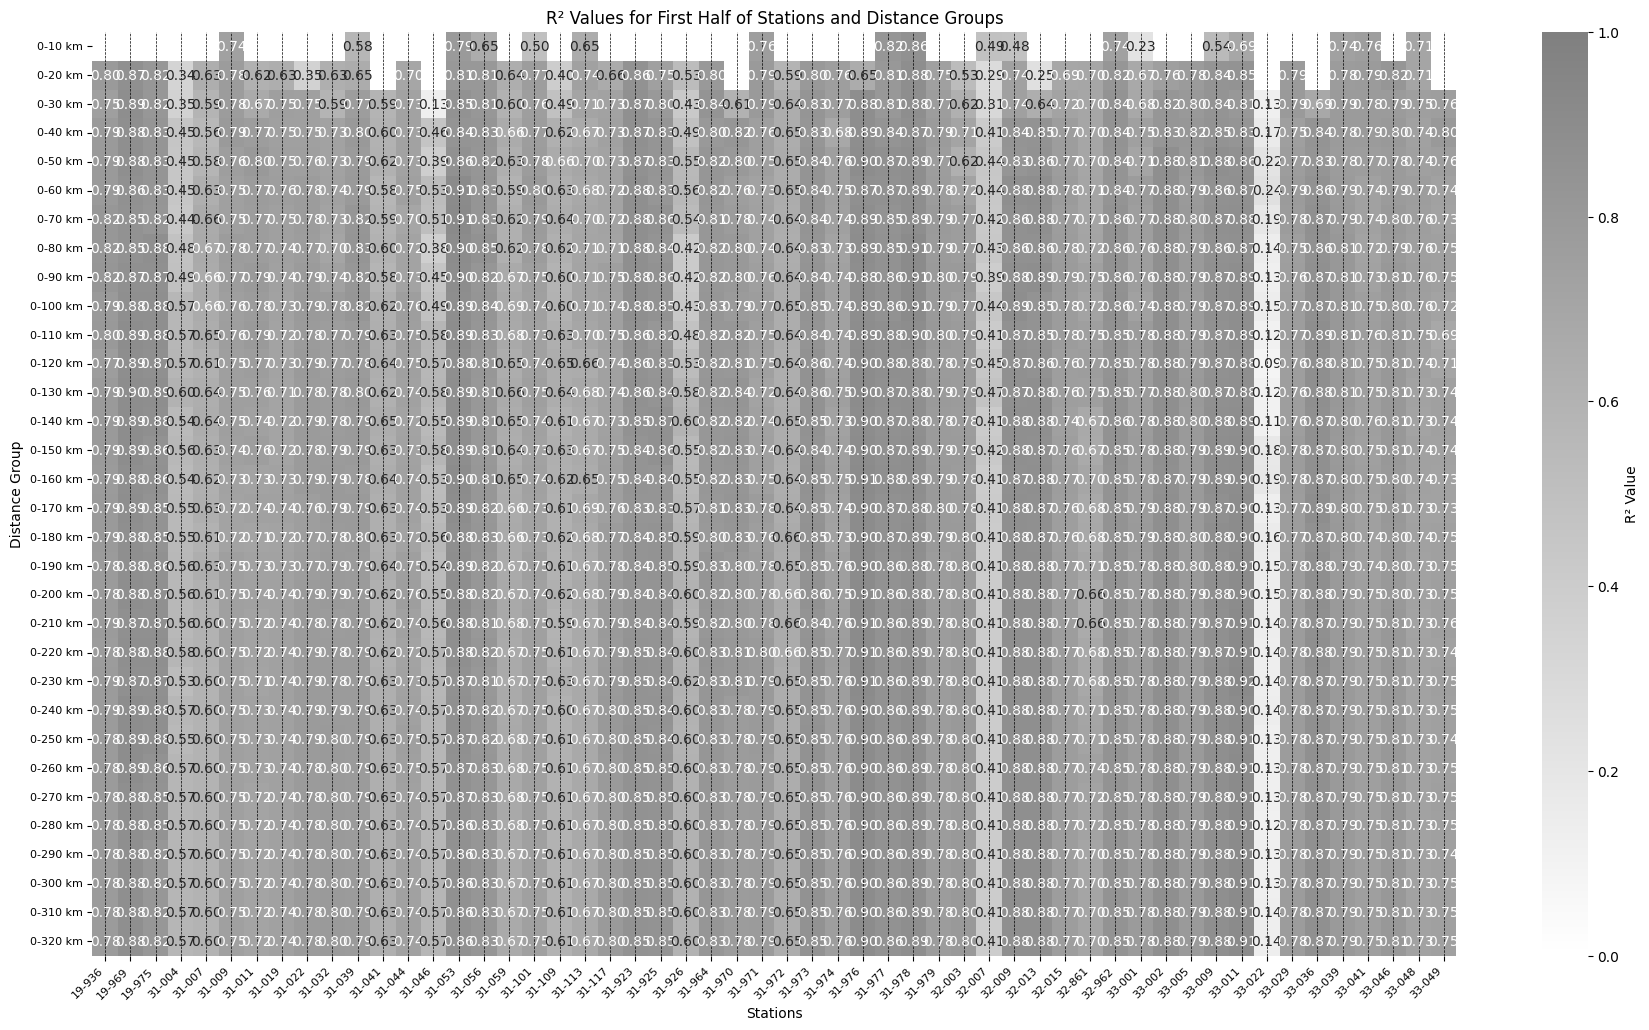

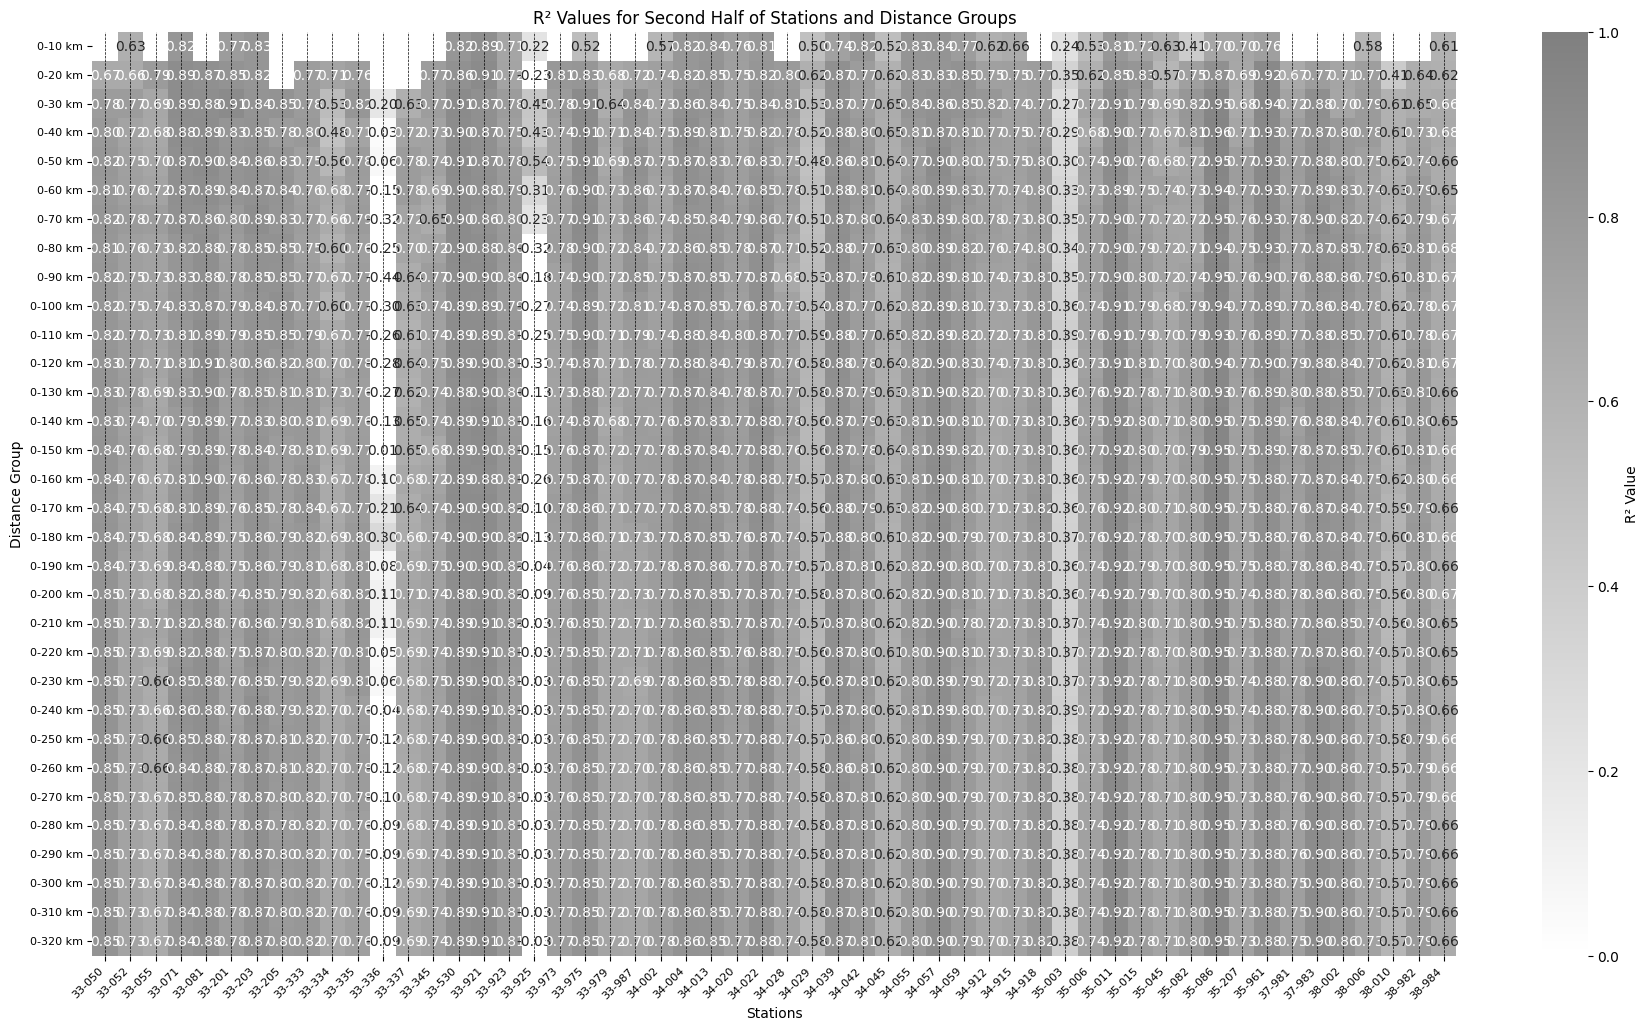

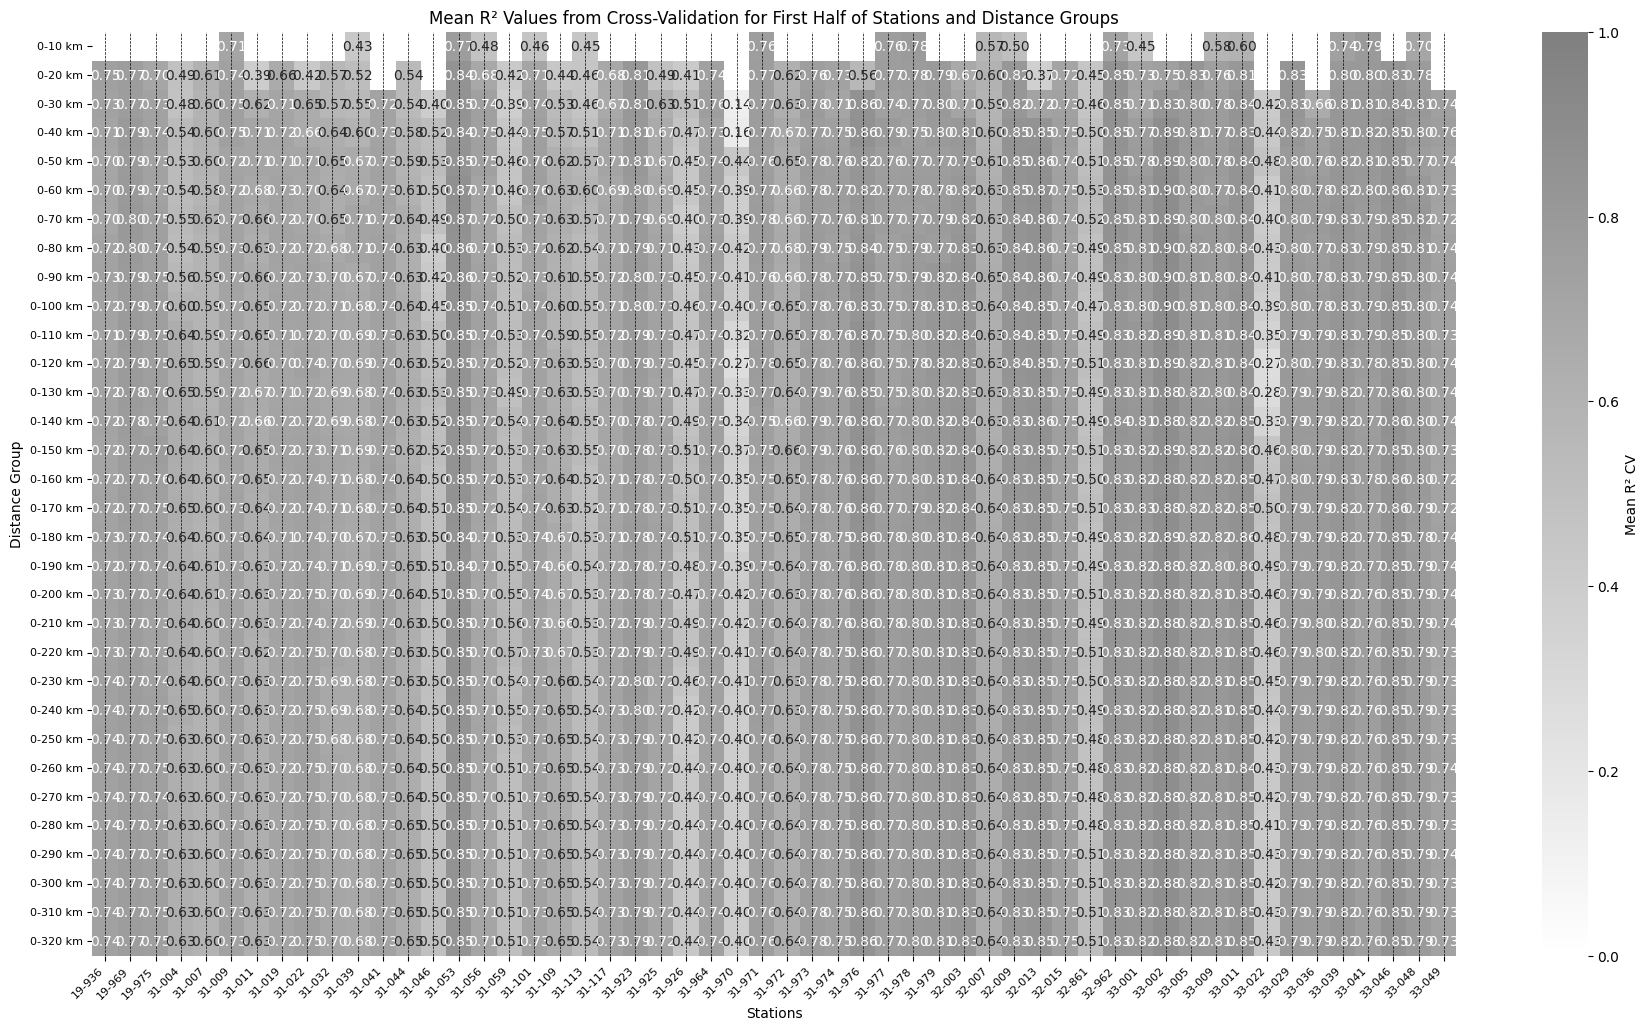

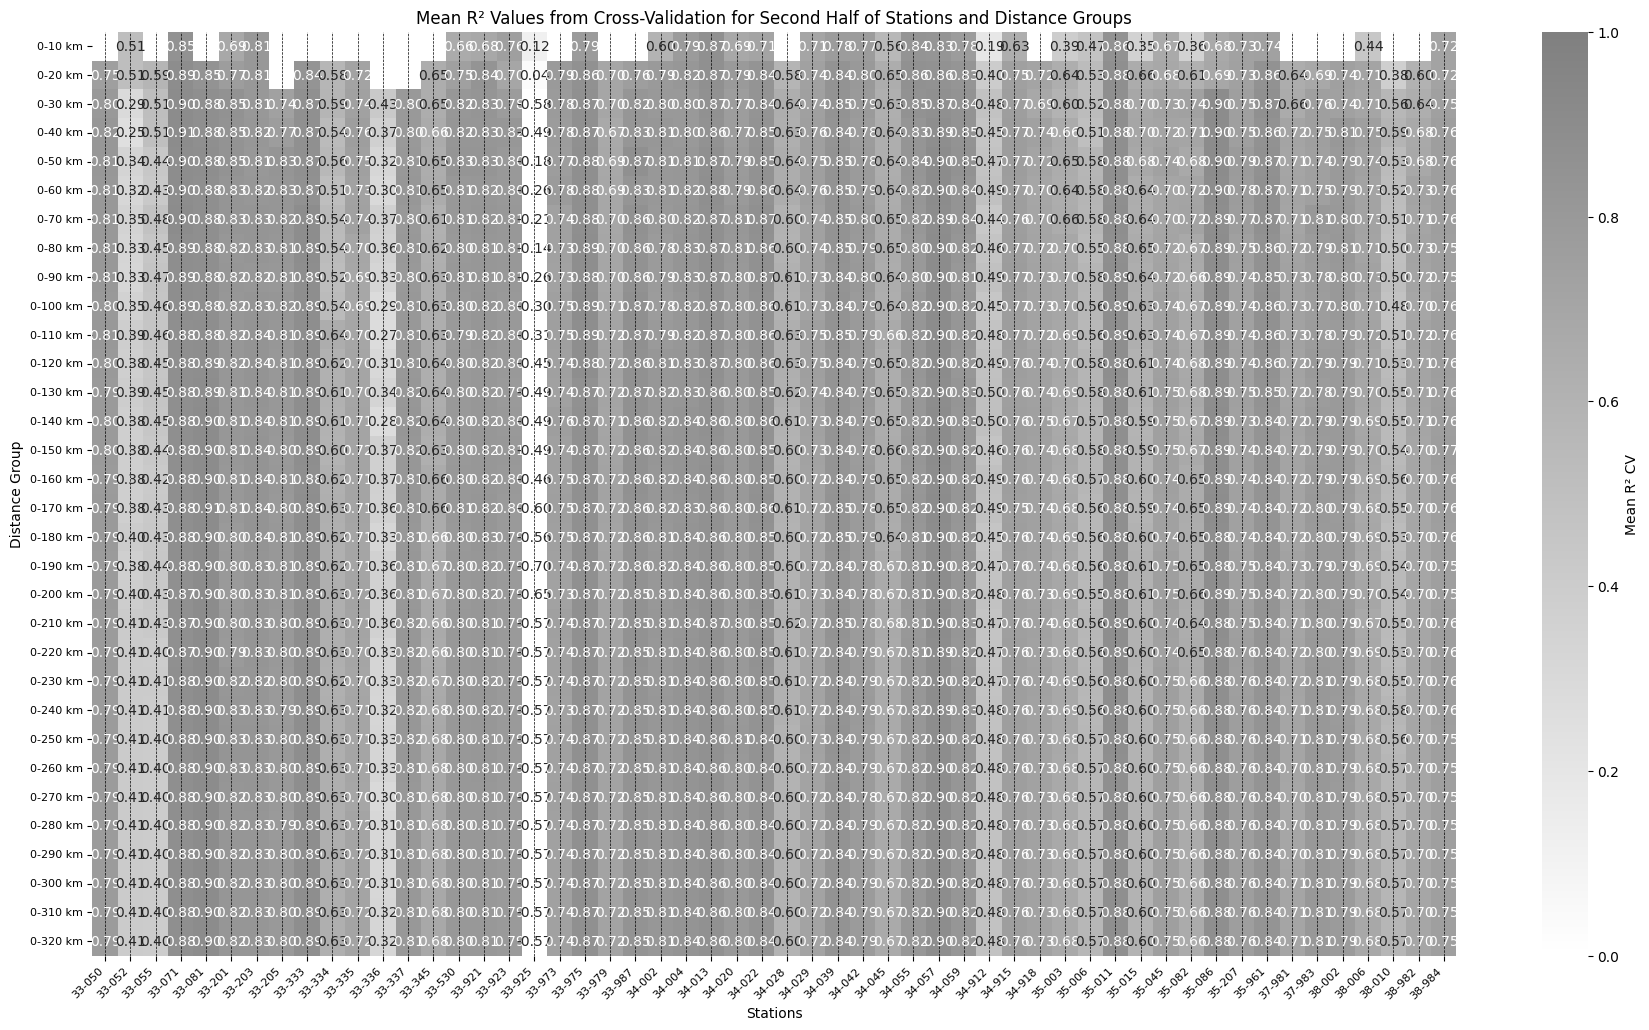

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

# Define the output folder for plots
output_plot_folder = 'F:/precip/precip/paper/'

# Function to extract the upper bound of the distance range, handling additional text
def extract_distance_value(distance_group):
    # Remove any non-numeric characters and extract the upper bound
    distance_str = distance_group.split('-')[1].strip()
    distance_value = int(''.join(filter(str.isdigit, distance_str)))
    return distance_value

# Apply the function to create a new column with sortable numeric values
results_df['Distance Value'] = results_df['Distance Group'].apply(extract_distance_value)

# Sort the DataFrame by the new 'Distance Value' column
results_df = results_df.sort_values('Distance Value')

# Pivot data to create a matrix for the heatmap of R² values
heatmap_data_r2 = results_df.pivot(index='Distance Group', columns='Station', values='R2')

# Ensure Distance Groups are sorted correctly
heatmap_data_r2 = heatmap_data_r2.reindex(sorted(heatmap_data_r2.index, key=lambda x: extract_distance_value(x)))

# Pivot data to create a matrix for the heatmap of Cross-Validation R² values
heatmap_data_cv_r2 = results_df.pivot(index='Distance Group', columns='Station', values='Mean R2 CV')

# Ensure Distance Groups are sorted correctly
heatmap_data_cv_r2 = heatmap_data_cv_r2.reindex(sorted(heatmap_data_cv_r2.index, key=lambda x: extract_distance_value(x)))

# Split the stations into two halves
stations = heatmap_data_r2.columns
midpoint = len(stations) // 2
stations_first_half = stations[:midpoint]
stations_second_half = stations[midpoint:]

# Create a custom colormap from white to gray
cmap = LinearSegmentedColormap.from_list('gray_white', ['white', 'gray'])

# Create the first heatmap (first half of stations) for R² values
heatmap_data_r2_first_half = heatmap_data_r2[stations_first_half]

fig, ax = plt.subplots(figsize=(22, 12))  # Increase width and height for better readability
sns.heatmap(heatmap_data_r2_first_half, cmap=cmap, ax=ax, cbar_kws={'label': 'R² Value'}, annot=True, fmt='.2f', vmin=0, vmax=1)

# Set gridlines on the x-axis for major ticks
ax.grid(True, which='major', axis='x', color='black', linestyle='--', linewidth=0.5)

ax.set_xlabel('Stations', fontsize=10)  # Adjust font size
ax.set_ylabel('Distance Group', fontsize=10)  # Adjust font size
ax.set_title('R² Values for First Half of Stations and Distance Groups', fontsize=12)  # Adjust font size
plt.xticks(rotation=45, ha='right', fontsize=8)  # Rotate labels and adjust font size
plt.yticks(fontsize=8)  # Adjust y-axis labels if needed
plt.savefig(f'{output_plot_folder}r2_heatmap_first_half_stations_with_gridlines.png', dpi=300, bbox_inches='tight')
plt.show()

# Create the second heatmap (second half of stations) for R² values
heatmap_data_r2_second_half = heatmap_data_r2[stations_second_half]

fig, ax = plt.subplots(figsize=(22, 12))  # Increase width and height for better readability
sns.heatmap(heatmap_data_r2_second_half, cmap=cmap, ax=ax, cbar_kws={'label': 'R² Value'}, annot=True, fmt='.2f', vmin=0, vmax=1)

# Set gridlines on the x-axis for major ticks
ax.grid(True, which='major', axis='x', color='black', linestyle='--', linewidth=0.5)

ax.set_xlabel('Stations', fontsize=10)  # Adjust font size
ax.set_ylabel('Distance Group', fontsize=10)  # Adjust font size
ax.set_title('R² Values for Second Half of Stations and Distance Groups', fontsize=12)  # Adjust font size
plt.xticks(rotation=45, ha='right', fontsize=8)  # Rotate labels and adjust font size
plt.yticks(fontsize=8)  # Adjust y-axis labels if needed
plt.savefig(f'{output_plot_folder}r2_heatmap_second_half_stations_with_gridlines.png', dpi=300, bbox_inches='tight')
plt.show()

# Create the first heatmap (first half of stations) for Cross-Validation R² values
heatmap_data_cv_r2_first_half = heatmap_data_cv_r2[stations_first_half]

fig, ax = plt.subplots(figsize=(22, 12))  # Increase width and height for better readability
sns.heatmap(heatmap_data_cv_r2_first_half, cmap=cmap, ax=ax, cbar_kws={'label': 'Mean R² CV'}, annot=True, fmt='.2f', vmin=0, vmax=1)

# Set gridlines on the x-axis for major ticks
ax.grid(True, which='major', axis='x', color='black', linestyle='--', linewidth=0.5)

ax.set_xlabel('Stations', fontsize=10)  # Adjust font size
ax.set_ylabel('Distance Group', fontsize=10)  # Adjust font size
ax.set_title('Mean R² Values from Cross-Validation for First Half of Stations and Distance Groups', fontsize=12)  # Adjust font size
plt.xticks(rotation=45, ha='right', fontsize=8)  # Rotate labels and adjust font size
plt.yticks(fontsize=8)  # Adjust y-axis labels if needed
plt.savefig(f'{output_plot_folder}cv_r2_heatmap_first_half_stations_with_gridlines.png', dpi=300, bbox_inches='tight')
plt.show()

# Create the second heatmap (second half of stations) for Cross-Validation R² values
heatmap_data_cv_r2_second_half = heatmap_data_cv_r2[stations_second_half]

fig, ax = plt.subplots(figsize=(22, 12))  # Increase width and height for better readability
sns.heatmap(heatmap_data_cv_r2_second_half, cmap=cmap, ax=ax, cbar_kws={'label': 'Mean R² CV'}, annot=True, fmt='.2f', vmin=0, vmax=1)

# Set gridlines on the x-axis for major ticks
ax.grid(True, which='major', axis='x', color='black', linestyle='--', linewidth=0.5)

ax.set_xlabel('Stations', fontsize=10)  # Adjust font size
ax.set_ylabel('Distance Group', fontsize=10)  # Adjust font size
ax.set_title('Mean R² Values from Cross-Validation for Second Half of Stations and Distance Groups', fontsize=12)  # Adjust font size
plt.xticks(rotation=45, ha='right', fontsize=8)  # Rotate labels and adjust font size
plt.yticks(fontsize=8)  # Adjust y-axis labels if needed
plt.savefig(f'{output_plot_folder}cv_r2_heatmap_second_half_stations_with_gridlines.png', dpi=300, bbox_inches='tight')
plt.show()



In [17]:
import pandas as pd

# Assuming station_counts_df contains the count of suitable stations for each distance group
# and results_df contains the evaluation results including R² values.

# Define the thresholds for R² values
thresholds = [0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]

# Function to extract the upper bound of the distance range, handling additional text
def extract_distance_value(distance_group):
    distance_str = distance_group.split('-')[1].strip()
    distance_value = int(''.join(filter(str.isdigit, distance_str)))
    return distance_value

# Apply the function to create a new column with sortable numeric values
results_df['Distance Value'] = results_df['Distance Group'].apply(extract_distance_value)

# Initialize an empty DataFrame to store the summary results
summary_df = pd.DataFrame()

# Process each threshold
for threshold in thresholds:
    # Filter data where R² value is greater than the current threshold
    filtered_df = results_df[results_df['R2'] > threshold]
    
    # Sort the DataFrame by station and then by distance value
    filtered_df = filtered_df.sort_values(by=['Station', 'Distance Value'])
    
    # Find the first distance group for each station
    first_valid_groups = filtered_df.groupby('Station').first().reset_index()
    
    # Rename the 'Distance Group' column to indicate the threshold
    first_valid_groups = first_valid_groups[['Station', 'Distance Group']].rename(columns={'Distance Group': f'Distance Group > {threshold}'})
    
    # Merge with the summary DataFrame
    if summary_df.empty:
        summary_df = first_valid_groups
    else:
        summary_df = pd.merge(summary_df, first_valid_groups, on='Station', how='left')

# Create a function to add the count of suitable stations
def add_station_counts(summary_df, station_counts_df):
    for threshold in thresholds:
        distance_group_col = f'Distance Group > {threshold}'
        
        # Merge station counts for the relevant distance groups
        merged_df = pd.merge(summary_df, station_counts_df[['Distance Group', 'Count']], 
                             left_on=distance_group_col, right_on='Distance Group', how='left')
        
        # Create a column with the count of suitable stations
        summary_df[f'{distance_group_col} (Count)'] = merged_df['Count'].fillna(0).astype(int)
    
    return summary_df

# Add the counts to the summary DataFrame
summary_df = add_station_counts(summary_df, station_counts_df)

# Save the summary table to an Excel file
summary_df.to_excel('F:/precip/precip/paper/distance_groups_with_counts22.xlsx', index=False)

print("Summary table with counts saved successfully.")

Summary table with counts saved successfully.


In [22]:
import pandas as pd

# Define the thresholds for R² values
thresholds = [0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]

# Function to extract the upper bound of the distance range, handling additional text
def extract_distance_value(distance_group):
    distance_str = distance_group.split('-')[1].strip()
    distance_value = int(''.join(filter(str.isdigit, distance_str)))
    return distance_value

# Apply the function to create a new column with sortable numeric values
results_df['Distance Value'] = results_df['Distance Group'].apply(extract_distance_value)

# Initialize an empty DataFrame to store the summary results
summary_df = pd.DataFrame()

# Process each threshold
for threshold in thresholds:
    # Filter data where R² value is greater than the current threshold
    filtered_df = results_df[results_df['R2'] > threshold]
    
    # Sort the DataFrame by station and then by distance value
    filtered_df = filtered_df.sort_values(by=['Station', 'Distance Value'])
    
    # Find the first distance group for each station that meets the threshold
    first_valid_groups = filtered_df.groupby('Station').first().reset_index()
    
    # Rename the 'Distance Group' column to indicate the threshold
    first_valid_groups = first_valid_groups[['Station', 'Distance Group']].rename(columns={'Distance Group': f'Distance Group > {threshold}'})
    
    # Merge with the summary DataFrame
    if summary_df.empty:
        summary_df = first_valid_groups
    else:
        summary_df = pd.merge(summary_df, first_valid_groups, on='Station', how='left')

# Ensure station_counts_df has the correct format
station_counts_df = station_counts_df.rename(columns={'Count': 'Count'})

# Create a function to add the count of suitable stations
def add_station_counts(summary_df, station_counts_df):
    # Ensure 'Distance Group' column names in station_counts_df match the ones in summary_df
    station_counts_df = station_counts_df.rename(columns={'Distance Group': 'Distance Group', 'Count': 'Count'})
    
    for threshold in thresholds:
        distance_group_col = f'Distance Group > {threshold}'
        
        # Merge station counts for the relevant distance groups
        merged_df = pd.merge(summary_df, station_counts_df[['Distance Group', 'Count']], 
                             left_on=distance_group_col, right_on='Distance Group', how='left')
        
        # Create a column with the count of suitable stations
        summary_df[f'{distance_group_col} (Count)'] = merged_df['Count'].fillna(0).astype(int)
    
    return summary_df

# Add the counts to the summary DataFrame
summary_df = add_station_counts(summary_df, station_counts_df)

# Save the summary table to an Excel file
summary_df.to_excel('F:/precip/precip/paper/distance_groups_with_counts.xlsx', index=False)

print("Summary table with counts saved successfully.")


Summary table with counts saved successfully.


In [25]:
import pandas as pd

# Define the thresholds for R² values
thresholds = [0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]

# Function to extract the upper bound of the distance range, handling additional text
def extract_distance_value(distance_group):
    distance_str = distance_group.split('-')[1].strip()
    distance_value = int(''.join(filter(str.isdigit, distance_str)))
    return distance_value

# Apply the function to create a new column with sortable numeric values
results_df['Distance Value'] = results_df['Distance Group'].apply(extract_distance_value)

# Initialize an empty DataFrame to store the summary results
summary_df = pd.DataFrame()

# Process each threshold
for threshold in thresholds:
    # Filter data where R² value is greater than the current threshold
    filtered_df = results_df[results_df['R2'] > threshold]
    
    # Sort the DataFrame by station and then by distance value
    filtered_df = filtered_df.sort_values(by=['Station', 'Distance Value'])
    
    # Find the first distance group for each station that meets the threshold
    first_valid_groups = filtered_df.groupby('Station').first().reset_index()
    
    # Rename the 'Distance Group' column to indicate the threshold
    first_valid_groups = first_valid_groups[['Station', 'Distance Group']].rename(columns={'Distance Group': f'Distance Group > {threshold}'})
    
    # Merge with the summary DataFrame
    if summary_df.empty:
        summary_df = first_valid_groups
    else:
        summary_df = pd.merge(summary_df, first_valid_groups, on='Station', how='left')

# Save the summary table to an Excel file
summary_df.to_excel('F:/precip/precip/paper/distance_groups_summary.xlsx', index=False)

print("Summary table saved successfully.")


Summary table saved successfully.


In [31]:
# List to store count of suitable stations for each distance group and target station
suitable_station_counts = []


In [34]:
# Convert results to DataFrames
stations_with_missing_data 

Index(['19-936', '19-969', '19-975', '31-004', '31-007', '31-009', '31-011',
       '31-019', '31-022', '31-032',
       ...
       '35-086', '35-207', '35-961', '37-981', '37-983', '38-002', '38-006',
       '38-010', '38-982', '38-984'],
      dtype='object', name='station', length=108)

In [36]:
for target_station in stations_with_missing_data:
    print(f"\nEvaluating for target station: {target_station}")
    
    for group in distance_groups:
        group_name = f"{group[0]}-{group[1]} km"
        print(f"\nEvaluating group: {group_name}")
        
        # Find suitable stations for the target station
        suitable_stations = find_suitable_stations_by_group(target_station, group)
        
        # Print suitable stations
        print(f"Suitable stations for station {target_station} in group {group_name}: {suitable_stations}")
        
        if suitable_stations:
            combined_df = filtered_df[[target_station] + suitable_stations].copy()
            combined_df = combined_df.dropna(subset=[target_station])
            
            if len(combined_df) < 10:  # Example check for minimum data points
                print(f"Not enough data points for station {target_station} in group {group_name}.")
                continue
            
            X = combined_df[suitable_stations].values
            y = combined_df[target_station].values
            
            valid_indices = ~np.isnan(y)
            X = X[valid_indices]
            y = y[valid_indices]
            
            # Define the pipeline
            pipeline = Pipeline([
                ('scaler', StandardScaler()),
                ('regr', HistGradientBoostingRegressor())
            ])
            
            # Perform cross-validation and calculate average metrics
            cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring='r2')
            mean_r2 = np.mean(cv_scores)
            
            # Calculate additional metrics
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
            pipeline.fit(X_train, y_train)
            y_pred = pipeline.predict(X_test)
            
            mse = mean_squared_error(y_test, y_pred)
            rmse = np.sqrt(mse)
            mae = mean_absolute_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)
            
            evaluation_results.append({
                'Distance Group': group_name,
                'Station': target_station,
                'Suitable Stations': suitable_stations,  # Add suitable stations to results
                'Mean R2 CV': mean_r2,
                'MSE': mse,
                'RMSE': rmse,
                'MAE': mae,
                'R2': r2
            })
            
            print(f"R² Score for station {target_station} in group {group_name}: {r2:.4f}")
            print(f"Mean R² from Cross-Validation for station {target_station} in group {group_name}: {mean_r2:.4f}")
        else:
            print(f"No suitable stations found for station {target_station} in group {group_name}.")



Evaluating for target station: 19-936

Evaluating group: 0-10 km
Suitable stations for station 19-936 in group 0-10 km: []
No suitable stations found for station 19-936 in group 0-10 km.

Evaluating group: 0-20 km
Suitable stations for station 19-936 in group 0-20 km: ['31-032', '31-923', '31-971']
R² Score for station 19-936 in group 0-20 km: 0.7963
Mean R² from Cross-Validation for station 19-936 in group 0-20 km: 0.7490

Evaluating group: 0-30 km
Suitable stations for station 19-936 in group 0-30 km: ['31-001', '31-004', '31-032', '31-053', '31-056', '31-109', '31-923', '31-971', '31-972']
R² Score for station 19-936 in group 0-30 km: 0.7527
Mean R² from Cross-Validation for station 19-936 in group 0-30 km: 0.7318

Evaluating group: 0-40 km
Suitable stations for station 19-936 in group 0-40 km: ['19-969', '31-001', '31-004', '31-032', '31-053', '31-056', '31-109', '31-923', '31-970', '31-971', '31-972', '31-973', '32-861']
R² Score for station 19-936 in group 0-40 km: 0.7917
Mean R

KeyboardInterrupt: 

In [37]:
# Function to find suitable stations by group and return count
def find_suitable_stations_by_group(station_with_missing_data, group):
    suitable_stations = []
    
    for station in filtered_df.columns:
        if station != station_with_missing_data:
            # Calculate distance between the current station and other stations
            distance = distances_km[locations.index.get_loc(station_with_missing_data), locations.index.get_loc(station)]
            if group[0] <= distance < group[1]:
                suitable_stations.append(station)
    
    # Return both the list of suitable stations and their count
    return suitable_stations, len(suitable_stations)

# Evaluate model performance for each station with missing values
for target_station in stations_with_missing_data:
    print(f"\nEvaluating for target station: {target_station}")
    
    for group in distance_groups:
        group_name = f"{group[0]}-{group[1]} km"
        print(f"\nEvaluating group: {group_name}")
        
        # Find suitable stations and their count
        suitable_stations, count_suitable = find_suitable_stations_by_group(target_station, group)
        
        # Print the number of suitable stations found
        print(f"Number of suitable stations for {target_station} in group {group_name}: {count_suitable}")
        
        if suitable_stations:
            combined_df = filtered_df[[target_station] + suitable_stations].copy()
            combined_df = combined_df.dropna(subset=[target_station])
            
            if len(combined_df) < 10:  # Example check for minimum data points
                print(f"Not enough data points for station {target_station} in group {group_name}.")
                continue
            
            X = combined_df[suitable_stations].values
            y = combined_df[target_station].values
            
            valid_indices = ~np.isnan(y)
            X = X[valid_indices]
            y = y[valid_indices]
            
            # Define the pipeline
            pipeline = Pipeline([
                ('scaler', StandardScaler()),
                ('regr', HistGradientBoostingRegressor())
            ])
            
            # Perform cross-validation and calculate average metrics
            cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring='r2')  # Using R² as the scoring metric
            mean_r2 = np.mean(cv_scores)
            
            # Calculate additional metrics using a split for demonstration
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
            pipeline.fit(X_train, y_train)
            y_pred = pipeline.predict(X_test)
            
            mse = mean_squared_error(y_test, y_pred)
            rmse = np.sqrt(mse)
            mae = mean_absolute_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)
            
            evaluation_results.append({
                'Distance Group': group_name,
                'Station': target_station,
                'Mean R2 CV': mean_r2,
                'MSE': mse,
                'RMSE': rmse,
                'MAE': mae,
                'R2': r2,
                'Count Suitable Stations': count_suitable  # Add the count here
            })
            
            print(f"R² Score for station {target_station} in group {group_name}: {r2:.4f}")
            print(f"Mean R² from Cross-Validation for station {target_station} in group {group_name}: {mean_r2:.4f}")
        else:
            print(f"No suitable stations found for station {target_station} in group {group_name}.")



Evaluating for target station: 19-936

Evaluating group: 0-10 km
Number of suitable stations for 19-936 in group 0-10 km: 0
No suitable stations found for station 19-936 in group 0-10 km.

Evaluating group: 0-20 km
Number of suitable stations for 19-936 in group 0-20 km: 3
R² Score for station 19-936 in group 0-20 km: 0.7963
Mean R² from Cross-Validation for station 19-936 in group 0-20 km: 0.7490

Evaluating group: 0-30 km
Number of suitable stations for 19-936 in group 0-30 km: 9
R² Score for station 19-936 in group 0-30 km: 0.7527
Mean R² from Cross-Validation for station 19-936 in group 0-30 km: 0.7318

Evaluating group: 0-40 km
Number of suitable stations for 19-936 in group 0-40 km: 13
R² Score for station 19-936 in group 0-40 km: 0.7917
Mean R² from Cross-Validation for station 19-936 in group 0-40 km: 0.7135

Evaluating group: 0-50 km
Number of suitable stations for 19-936 in group 0-50 km: 17
R² Score for station 19-936 in group 0-50 km: 0.7918
Mean R² from Cross-Validation f

D:\anacon\envs\sep_2021\Lib\site-packages\sklearn\utils\extmath.py:1050: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
D:\anacon\envs\sep_2021\Lib\site-packages\sklearn\utils\extmath.py:1055: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
D:\anacon\envs\sep_2021\Lib\site-packages\sklearn\utils\extmath.py:1075: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


R² Score for station 31-101 in group 0-120 km: 0.7400
Mean R² from Cross-Validation for station 31-101 in group 0-120 km: 0.7281

Evaluating group: 0-130 km
Number of suitable stations for 31-101 in group 0-130 km: 76


D:\anacon\envs\sep_2021\Lib\site-packages\sklearn\utils\extmath.py:1050: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
D:\anacon\envs\sep_2021\Lib\site-packages\sklearn\utils\extmath.py:1055: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
D:\anacon\envs\sep_2021\Lib\site-packages\sklearn\utils\extmath.py:1075: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


R² Score for station 31-101 in group 0-130 km: 0.7540
Mean R² from Cross-Validation for station 31-101 in group 0-130 km: 0.7274

Evaluating group: 0-140 km
Number of suitable stations for 31-101 in group 0-140 km: 85


D:\anacon\envs\sep_2021\Lib\site-packages\sklearn\utils\extmath.py:1050: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
D:\anacon\envs\sep_2021\Lib\site-packages\sklearn\utils\extmath.py:1055: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
D:\anacon\envs\sep_2021\Lib\site-packages\sklearn\utils\extmath.py:1075: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


R² Score for station 31-101 in group 0-140 km: 0.7365
Mean R² from Cross-Validation for station 31-101 in group 0-140 km: 0.7272

Evaluating group: 0-150 km
Number of suitable stations for 31-101 in group 0-150 km: 95


D:\anacon\envs\sep_2021\Lib\site-packages\sklearn\utils\extmath.py:1050: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
D:\anacon\envs\sep_2021\Lib\site-packages\sklearn\utils\extmath.py:1055: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
D:\anacon\envs\sep_2021\Lib\site-packages\sklearn\utils\extmath.py:1075: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


R² Score for station 31-101 in group 0-150 km: 0.7322
Mean R² from Cross-Validation for station 31-101 in group 0-150 km: 0.7271

Evaluating group: 0-160 km
Number of suitable stations for 31-101 in group 0-160 km: 107


D:\anacon\envs\sep_2021\Lib\site-packages\sklearn\utils\extmath.py:1050: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
D:\anacon\envs\sep_2021\Lib\site-packages\sklearn\utils\extmath.py:1055: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
D:\anacon\envs\sep_2021\Lib\site-packages\sklearn\utils\extmath.py:1075: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


R² Score for station 31-101 in group 0-160 km: 0.7410
Mean R² from Cross-Validation for station 31-101 in group 0-160 km: 0.7197

Evaluating group: 0-170 km
Number of suitable stations for 31-101 in group 0-170 km: 125


D:\anacon\envs\sep_2021\Lib\site-packages\sklearn\utils\extmath.py:1050: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
D:\anacon\envs\sep_2021\Lib\site-packages\sklearn\utils\extmath.py:1055: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
D:\anacon\envs\sep_2021\Lib\site-packages\sklearn\utils\extmath.py:1075: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


R² Score for station 31-101 in group 0-170 km: 0.7316
Mean R² from Cross-Validation for station 31-101 in group 0-170 km: 0.7351

Evaluating group: 0-180 km
Number of suitable stations for 31-101 in group 0-180 km: 139


D:\anacon\envs\sep_2021\Lib\site-packages\sklearn\utils\extmath.py:1050: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
D:\anacon\envs\sep_2021\Lib\site-packages\sklearn\utils\extmath.py:1055: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
D:\anacon\envs\sep_2021\Lib\site-packages\sklearn\utils\extmath.py:1075: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


R² Score for station 31-101 in group 0-180 km: 0.7341
Mean R² from Cross-Validation for station 31-101 in group 0-180 km: 0.7391

Evaluating group: 0-190 km
Number of suitable stations for 31-101 in group 0-190 km: 149


D:\anacon\envs\sep_2021\Lib\site-packages\sklearn\utils\extmath.py:1050: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
D:\anacon\envs\sep_2021\Lib\site-packages\sklearn\utils\extmath.py:1055: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
D:\anacon\envs\sep_2021\Lib\site-packages\sklearn\utils\extmath.py:1075: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


R² Score for station 31-101 in group 0-190 km: 0.7548
Mean R² from Cross-Validation for station 31-101 in group 0-190 km: 0.7402

Evaluating group: 0-200 km
Number of suitable stations for 31-101 in group 0-200 km: 155


D:\anacon\envs\sep_2021\Lib\site-packages\sklearn\utils\extmath.py:1050: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
D:\anacon\envs\sep_2021\Lib\site-packages\sklearn\utils\extmath.py:1055: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
D:\anacon\envs\sep_2021\Lib\site-packages\sklearn\utils\extmath.py:1075: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


R² Score for station 31-101 in group 0-200 km: 0.7402
Mean R² from Cross-Validation for station 31-101 in group 0-200 km: 0.7372

Evaluating group: 0-210 km
Number of suitable stations for 31-101 in group 0-210 km: 159


D:\anacon\envs\sep_2021\Lib\site-packages\sklearn\utils\extmath.py:1050: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
D:\anacon\envs\sep_2021\Lib\site-packages\sklearn\utils\extmath.py:1055: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
D:\anacon\envs\sep_2021\Lib\site-packages\sklearn\utils\extmath.py:1075: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


R² Score for station 31-101 in group 0-210 km: 0.7455
Mean R² from Cross-Validation for station 31-101 in group 0-210 km: 0.7344

Evaluating group: 0-220 km
Number of suitable stations for 31-101 in group 0-220 km: 160


D:\anacon\envs\sep_2021\Lib\site-packages\sklearn\utils\extmath.py:1050: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
D:\anacon\envs\sep_2021\Lib\site-packages\sklearn\utils\extmath.py:1055: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
D:\anacon\envs\sep_2021\Lib\site-packages\sklearn\utils\extmath.py:1075: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


R² Score for station 31-101 in group 0-220 km: 0.7455
Mean R² from Cross-Validation for station 31-101 in group 0-220 km: 0.7344

Evaluating group: 0-230 km
Number of suitable stations for 31-101 in group 0-230 km: 160


D:\anacon\envs\sep_2021\Lib\site-packages\sklearn\utils\extmath.py:1050: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
D:\anacon\envs\sep_2021\Lib\site-packages\sklearn\utils\extmath.py:1055: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
D:\anacon\envs\sep_2021\Lib\site-packages\sklearn\utils\extmath.py:1075: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


R² Score for station 31-101 in group 0-230 km: 0.7455
Mean R² from Cross-Validation for station 31-101 in group 0-230 km: 0.7344

Evaluating group: 0-240 km
Number of suitable stations for 31-101 in group 0-240 km: 161


D:\anacon\envs\sep_2021\Lib\site-packages\sklearn\utils\extmath.py:1050: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
D:\anacon\envs\sep_2021\Lib\site-packages\sklearn\utils\extmath.py:1055: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
D:\anacon\envs\sep_2021\Lib\site-packages\sklearn\utils\extmath.py:1075: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


R² Score for station 31-101 in group 0-240 km: 0.7455
Mean R² from Cross-Validation for station 31-101 in group 0-240 km: 0.7344

Evaluating group: 0-250 km
Number of suitable stations for 31-101 in group 0-250 km: 161


D:\anacon\envs\sep_2021\Lib\site-packages\sklearn\utils\extmath.py:1050: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
D:\anacon\envs\sep_2021\Lib\site-packages\sklearn\utils\extmath.py:1055: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
D:\anacon\envs\sep_2021\Lib\site-packages\sklearn\utils\extmath.py:1075: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


R² Score for station 31-101 in group 0-250 km: 0.7455
Mean R² from Cross-Validation for station 31-101 in group 0-250 km: 0.7344

Evaluating group: 0-260 km
Number of suitable stations for 31-101 in group 0-260 km: 161


D:\anacon\envs\sep_2021\Lib\site-packages\sklearn\utils\extmath.py:1050: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
D:\anacon\envs\sep_2021\Lib\site-packages\sklearn\utils\extmath.py:1055: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
D:\anacon\envs\sep_2021\Lib\site-packages\sklearn\utils\extmath.py:1075: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


R² Score for station 31-101 in group 0-260 km: 0.7455
Mean R² from Cross-Validation for station 31-101 in group 0-260 km: 0.7344

Evaluating group: 0-270 km
Number of suitable stations for 31-101 in group 0-270 km: 161


D:\anacon\envs\sep_2021\Lib\site-packages\sklearn\utils\extmath.py:1050: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
D:\anacon\envs\sep_2021\Lib\site-packages\sklearn\utils\extmath.py:1055: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
D:\anacon\envs\sep_2021\Lib\site-packages\sklearn\utils\extmath.py:1075: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


R² Score for station 31-101 in group 0-270 km: 0.7455
Mean R² from Cross-Validation for station 31-101 in group 0-270 km: 0.7344

Evaluating group: 0-280 km
Number of suitable stations for 31-101 in group 0-280 km: 161


D:\anacon\envs\sep_2021\Lib\site-packages\sklearn\utils\extmath.py:1050: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
D:\anacon\envs\sep_2021\Lib\site-packages\sklearn\utils\extmath.py:1055: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
D:\anacon\envs\sep_2021\Lib\site-packages\sklearn\utils\extmath.py:1075: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


R² Score for station 31-101 in group 0-280 km: 0.7455
Mean R² from Cross-Validation for station 31-101 in group 0-280 km: 0.7344

Evaluating group: 0-290 km
Number of suitable stations for 31-101 in group 0-290 km: 161


D:\anacon\envs\sep_2021\Lib\site-packages\sklearn\utils\extmath.py:1050: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
D:\anacon\envs\sep_2021\Lib\site-packages\sklearn\utils\extmath.py:1055: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
D:\anacon\envs\sep_2021\Lib\site-packages\sklearn\utils\extmath.py:1075: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


R² Score for station 31-101 in group 0-290 km: 0.7455
Mean R² from Cross-Validation for station 31-101 in group 0-290 km: 0.7344

Evaluating group: 0-300 km
Number of suitable stations for 31-101 in group 0-300 km: 161


D:\anacon\envs\sep_2021\Lib\site-packages\sklearn\utils\extmath.py:1050: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
D:\anacon\envs\sep_2021\Lib\site-packages\sklearn\utils\extmath.py:1055: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
D:\anacon\envs\sep_2021\Lib\site-packages\sklearn\utils\extmath.py:1075: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


R² Score for station 31-101 in group 0-300 km: 0.7455
Mean R² from Cross-Validation for station 31-101 in group 0-300 km: 0.7344

Evaluating group: 0-310 km
Number of suitable stations for 31-101 in group 0-310 km: 161


D:\anacon\envs\sep_2021\Lib\site-packages\sklearn\utils\extmath.py:1050: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
D:\anacon\envs\sep_2021\Lib\site-packages\sklearn\utils\extmath.py:1055: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
D:\anacon\envs\sep_2021\Lib\site-packages\sklearn\utils\extmath.py:1075: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


R² Score for station 31-101 in group 0-310 km: 0.7455
Mean R² from Cross-Validation for station 31-101 in group 0-310 km: 0.7344

Evaluating group: 0-320 km
Number of suitable stations for 31-101 in group 0-320 km: 161


D:\anacon\envs\sep_2021\Lib\site-packages\sklearn\utils\extmath.py:1050: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
D:\anacon\envs\sep_2021\Lib\site-packages\sklearn\utils\extmath.py:1055: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
D:\anacon\envs\sep_2021\Lib\site-packages\sklearn\utils\extmath.py:1075: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


R² Score for station 31-101 in group 0-320 km: 0.7455
Mean R² from Cross-Validation for station 31-101 in group 0-320 km: 0.7344

Evaluating for target station: 31-109

Evaluating group: 0-10 km
Number of suitable stations for 31-109 in group 0-10 km: 0
No suitable stations found for station 31-109 in group 0-10 km.

Evaluating group: 0-20 km
Number of suitable stations for 31-109 in group 0-20 km: 4
R² Score for station 31-109 in group 0-20 km: 0.3972
Mean R² from Cross-Validation for station 31-109 in group 0-20 km: 0.4435

Evaluating group: 0-30 km
Number of suitable stations for 31-109 in group 0-30 km: 9
R² Score for station 31-109 in group 0-30 km: 0.4883
Mean R² from Cross-Validation for station 31-109 in group 0-30 km: 0.5340

Evaluating group: 0-40 km
Number of suitable stations for 31-109 in group 0-40 km: 16
R² Score for station 31-109 in group 0-40 km: 0.6223
Mean R² from Cross-Validation for station 31-109 in group 0-40 km: 0.5657

Evaluating group: 0-50 km
Number of suita